# <center> Model Selection by Nested CV 

<center> <img src="https://github.com/brandon-park/spam_mail_prediction/blob/main/selection-process-for-hiring-rh-2018.jpg?raw=true" width="70%"/>

## TOC:

1. [Introduction](#Introduction)
2. [Import data](#Import-data)
3. [Feature selection using decision tree](#Feature-selection)
4. [Define model and set of hyperparameter](#Define-model)
5. [Run nested CV with normalization](#nested-CV)
6. [Draw ROC curve](#ROC)
7. [Select final model and optimize hyperparameter](#final-model)
8. [Conclusion/Limitation](#Conclusion)

## Introduction <a name="Introduction"></a>

### How to choose which 'model' is the best model for the certain data?

We all know that k-fold and cross validation is one of the golden rule to test the model's performance. **But there is one critical issue with this method. Traditional CV only use 1 set of hyperparameter to compare each k-fold. However, the model performance in a certain fold could be different with the different hyperparameter.**

To overcome the bias from using the same hyperparameter, we can use nested CV. Unlike traditional CV, nested CV again split the training fold(Outer loop) into traning-valid(Inner loop) to find the best hyperparameter for the outer fold. By doing so, we can resolve the bias and compare the models more precisely.

Besides, we will also draw ROC curve and compute AUC score as an alternative model selection method.

Finally, we identify the best model to optimize the hyperparameter.


### Reason for choosing 'precision' as a metric

The dataset is about the spam email classification. As stated in in the documentation, **'false positive'** is much critical in the business perspective when filterting spam. For example, it is strongly undesirable and need to be avoided if the actual ham email that contains important information is classified into spam. 

So in the second analysis, we aim to build a model that minimize the 'false positive' and high precision_positive at the same time. 



_disclaimer:
    The goal of this notebook is to showcase the model selection process. Hyper parameters used in each model are not optimized and hence the best model / performance are not literally 'the best' for this toy dataset._


## Import data <a name="Import-data"></a>

In [1]:
### Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean

from sklearn import model_selection
from sklearn.metrics import (confusion_matrix, roc_curve,roc_auc_score, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline

from scikitplot.metrics import plot_roc, plot_lift_curve
from tqdm import tqdm

import tensorflow as tf 
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

In [2]:
# Conduct train-test split and scaling
# It is important to use the same fitted scaler to both train and test.

def split_and_scale(X, y, test_size = 0.2, random_state = 77):
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=77)

    scaler_fit = StandardScaler().fit(X_train)

    X_train_scaled = scaler_fit.transform(X_train)
    X_test_scaled = scaler_fit.transform(X_test)

    print("Train data\'s shape:", X_train_scaled.shape)
    print("Valid data\'s shape:", X_test_scaled.shape)
    
    return X_train_scaled, X_test_scaled, y_train, y_test



# Nested Cross Validation with Randomized search CV
# Models should be pre-defined in dictionary


def nested_cv(models, scoring:str, X, y, num_trials, inner_splits, outer_splits, random_state = 77):

    total_scores = dict()

    print("="*50)
    for name, model, param in models:

        scores = []

        for i in tqdm(range(num_trials)):  # Try N times and take the mean score

            inner_cv = model_selection.KFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
            outer_cv = model_selection.KFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

            # Each inner_cv will scale and make prediction
            clf = model_selection.RandomizedSearchCV(estimator= Pipeline([('scaler', StandardScaler()),
                                                                     (name, model)])
                                               ,param_distributions=param, refit= True, scoring = scoring, cv=inner_cv)

            mean_score = model_selection.cross_val_score(clf, X=X, y=y, cv=outer_cv).mean()
            scores.append(mean_score)
        
        total_scores[name] = mean(scores)  
        print("Average score of {}: {}.".format(name, round(mean(scores),3)))

    print("="*50)
    
    return pd.DataFrame.from_dict(total_scores, orient='index', columns=['NestedCV'])

    
# Define the NN model

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=5, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics='Precision')
    
    return model


# Plot multiple ROC curve and compute AUC 

def roc_auc(models, scoring:str, X_selected, y_selected):
    
    X_selected_train_scaled, X_selected_test_scaled, y_selected_train, y_selected_test = split_and_scale(X_selected,y_selected)
    
    plt.figure(figsize=(10,5))
    total_scores = dict()

    for name, model, param in models:

        clf = model_selection.RandomizedSearchCV(estimator=Pipeline([(name, model)]), 
                                           param_distributions=param, scoring = scoring, cv=2)
        clf.fit(X_selected_train_scaled, y_selected_train)
        ypred = clf.predict(X_selected_test_scaled) 
        ypred_proba = clf.predict_proba(X_selected_test_scaled)[:,1]
        fpr, tpr, thresholds = roc_curve(y_selected_test, ypred_proba)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(y_selected_test,ypred)
        # Now, plot the computed values
        plt.plot(fpr, tpr, label= name)
        print("AUC score of {} is {:.3f}".format(name,auc))
        total_scores[name] = auc
        
    return pd.DataFrame.from_dict(total_scores, orient='index', columns=['AUC'])
        


In [3]:
# Import data
# https://archive.ics.uci.edu/ml/datasets/spambase

df = pd.read_csv("data/spambase.data", header = None)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
# Initial train/test split and scaling before feature selection

X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale(X,y)

Train data's shape: (3680, 57)
Valid data's shape: (921, 57)


## Feature selection using decision tree <a name="Feature-selection"></a>

<AxesSubplot:>

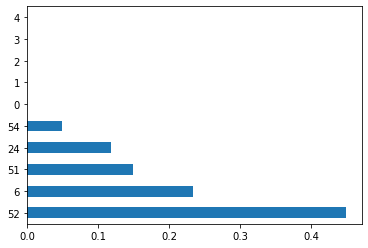

In [5]:
# Find the best hyperparameter by using feature_importances in Decision Tree

param = {'criterion': ["entropy"],
        'max_depth': np.arange(3,6,1),
        'min_samples_split': np.arange(7,10,1),
        'min_samples_leaf': np.arange(8,11,1),
        'max_leaf_nodes': np.arange(4,8,1),
        'random_state':[77]}

clf = model_selection.GridSearchCV(estimator=DecisionTreeClassifier(), 
                                   param_grid=param, refit= True, scoring = 'accuracy', cv=4)
clf.fit(X_train_scaled, y_train)

dt_clf = DecisionTreeClassifier().set_params(**clf.best_params_)
dt_clf.fit(X_train_scaled, y_train)

# Draw bar chart for top 10 features
feature_importances = pd.Series(dt_clf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')

In [6]:
# Filter the top 5 features
df_selected = df.iloc[:,[54,24,51,6,52,-1]]
X_selected = df_selected.iloc[:,:-1]
y_selected = df_selected.iloc[:,-1]
X_selected.head()

,54,24,51,6,52
0,3.756,0.0,0.778,0.00,0.000
1,5.114,0.0,0.372,0.21,0.180
2,9.821,0.0,0.276,0.19,0.184
3,3.537,0.0,0.137,0.31,0.000
4,3.537,0.0,0.135,0.31,0.000


## Define model and set of hyperparameter <a name="Define-model"></a>

In [7]:
# Define each model and the combination of hyper parameter for GridSearch

models = []
models.append(('LOG', 
               LogisticRegression(),
               {'LOG__solver': ["liblinear"],
                'LOG__penalty': ['l1','l2'],
                'LOG__C': [0.01, 0.1, 1, 10, 100],
                'LOG__random_state': [77],
                'LOG__max_iter': [500]
               }
              ))

models.append(('KNN', 
               KNeighborsClassifier(),
               {'KNN__n_neighbors': np.arange(3,15,1),
                'KNN__weights': ['uniform', 'distance']}
              ))

models.append(('DT', 
               DecisionTreeClassifier(), 
               {'DT__criterion': ["entropy"],
                'DT__max_depth': np.arange(4,8,1),
                'DT__min_samples_split': np.arange(7,10,1),
                'DT__random_state':[77]}
              ))

models.append(('SVC', 
               SVC(),
               {"SVC__C": [1,10, 100],
                "SVC__gamma": [1, 10],
                "SVC__kernel": ['rbf','linear'],
                "SVC__probability": [True],
                'SVC__random_state':[77]}
              ))
models.append(('LGBM', 
               LGBMClassifier(),
               {"LGBM__n_estimators": [300, 500, 1000],
                "LGBM__num_leaves": np.arange(5,9,1),
                "LGBM__learning_rate": [0.05, 0.1, 0.5],
                "LGBM__reg_lambda": [1,10, 50]}
              ))

models.append(('NN', 
               KerasClassifier(build_fn=create_model, verbose=0),
               {"NN__batch_size": [20, 60, 80, 100],
                "NN__epochs": [10, 50, 100]}
              ))

# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

## Run nested CV with normalization <a name="nested-CV"></a>

In [8]:
# Conduct nested CV from defind model and filtered data

result_nestedcv = nested_cv(models, scoring = 'precision', X = X_selected, y = y_selected,
                            num_trials = 2, inner_splits = 2, outer_splits = 2, random_state = 77)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Average score of LOG: 0.922.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


Average score of KNN: 0.901.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Average score of DT: 0.886.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:25<00:00, 12.73s/it]


Average score of SVC: 0.903.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.08s/it]


Average score of LGBM: 0.901.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.37s/it]

Average score of NN: 0.892.



## Draw ROC curve <a name="ROC"></a>

Train data's shape: (3680, 5)
Valid data's shape: (921, 5)
AUC score of LOG is 0.786
AUC score of KNN is 0.882
AUC score of DT is 0.893
AUC score of SVC is 0.841
AUC score of LGBM is 0.896
AUC score of NN is 0.862


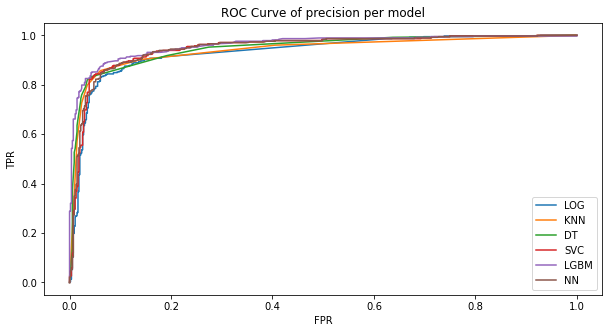

In [9]:
result_auc = roc_auc(models, 'precision', X_selected, y_selected)

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC Curve of precision per model')
plt.show()


In [10]:
final_result = pd.concat([result_nestedcv,result_auc], axis=1)
final_result['Mean'] = final_result.mean(axis =1)
final_result['Rank'] = final_result['Mean'].rank(method ='average', ascending=False).astype('int')
final_result.sort_values('Rank')

,NestedCV,AUC,Mean,Rank
LGBM,0.900546,0.896409,0.898477,1
KNN,0.900946,0.881976,0.891461,2
DT,0.885594,0.892558,0.889076,3
NN,0.891692,0.862017,0.876854,4
SVC,0.903153,0.840568,0.871861,5
LOG,0.921918,0.786452,0.854185,6


## Select final model and optimize hyperparameter <a name="final-model"></a>

In [11]:
# LGBM shows the best performance among all models
# Use randomized CV to optimize the best hyperparameter

X_selected_train_scaled, X_selected_test_scaled, y_selected_train, y_selected_test = split_and_scale(X_selected,y_selected)

param = {"LGBM__n_estimators": np.arange(100,1000,200),
        "LGBM__num_leaves": np.arange(100,2000,400),
        "LGBM__max_depth": np.arange(3,12,1),
        "LGBM__num_leaves": np.arange(5,15,1),
        "LGBM__num_leaves": np.arange(5,15,1),
        "LGBM__learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        "LGBM__reg_lambda": [1,10, 50]}

clf = model_selection.RandomizedSearchCV(estimator=Pipeline([('LGBM', LGBMClassifier())]), 
                                   param_distributions=param, refit= True, scoring = 'precision', cv=10, verbose=1)
clf.fit(X_selected_train_scaled, y_selected_train)
y_pred = clf.predict(X_selected_test_scaled) 


print("="*50)
print('Final model\'s Precision is {}'.format(round(clf.best_score_,3)))
print('Final model\'s best parameter is {}'.format(clf.best_params_))
print("="*50)

Train data's shape: (3680, 5)
Valid data's shape: (921, 5)
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Final model's Precision is 0.916
Final model's best parameter is {'LGBM__reg_lambda': 1, 'LGBM__num_leaves': 13, 'LGBM__n_estimators': 100, 'LGBM__max_depth': 4, 'LGBM__learning_rate': 0.3}


## Conclusion/Limitation <a name="Conclusion"></a>


### Conclusiion

- Nested CV and AUC showed different score
- LGBM was selected to be the best model after taking mean of Nested CV and AUC
- With optimized hyperparameter, LGBM has precision 0.916


### Limitation

- Taking mean of 2 scores has no technical reason and it is unsure which method is better between nested CV and AUC.
- In the interest of time, inner cv and outer cv iteration was set to 2. The result might be different with higher iteration
- Best hyperparameter could be different with GridSearchCV